# 📊 Validate Policy with Plots

This notebook compares the trained policy's action predictions against the ground truth actions from the training dataset.

This is useful to:
1. Verify the policy learned the correct behavior
2. Identify which action dimensions have high/low error
3. Debug issues before deploying to the robot

## 1. Configuration

Set the paths to your checkpoint and dataset.

In [1]:
from pathlib import Path
import os

# TODO: Set these paths
# Point directly to the pretrained_model folder containing config.json
CHECKPOINT_DIR = Path("outputs/train/006200/pretrained_model")

# Dataset path - try multiple locations
possible_dataset_paths = [
    Path("/data/single_stack_demo"),  # JupyterHub absolute
    Path("../../data/single_stack_demo"),  # JupyterHub relative
    Path("../data/single_stack_demo"),  # Local
    Path("../data/lerobot_output"),  # Local alternative
]

DATASET_DIR = None
for p in possible_dataset_paths:
    if p.exists():
        DATASET_DIR = p
        print(f"✅ Found dataset at: {p}")
        break
    else:
        print(f"❌ Not found: {p}")

if DATASET_DIR is None:
    print("\n⚠️ Please set DATASET_DIR manually")

# Episode to visualize
EPISODE_INDEX = 0

print(f"\nCheckpoint: {CHECKPOINT_DIR}")
print(f"Dataset: {DATASET_DIR}")
print(f"Episode: {EPISODE_INDEX}")

❌ Not found: /data/single_stack_demo
❌ Not found: ../../data/single_stack_demo
✅ Found dataset at: ../data/single_stack_demo

Checkpoint: outputs/train/006200/pretrained_model
Dataset: ../data/single_stack_demo
Episode: 0


## 2. Load Policy and Dataset

In [2]:
import torch
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from example_policies.robot_deploy.policy_loader import load_policy

# Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load policy
policy, cfg = load_policy(CHECKPOINT_DIR)
policy.to(device)
policy.eval()
print(f"✅ Policy loaded")

# Load dataset
dataset = LeRobotDataset(
    repo_id=str(DATASET_DIR),
    root=DATASET_DIR,
)
print(f"✅ Dataset loaded: {len(dataset)} frames")

/home/pw/Documents/Code/hackathon-example-policies/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Number of flow params: 42.13M
Loading weights from local directory
✅ Policy loaded
Number of flow params: 42.13M
Loading weights from local directory
✅ Policy loaded
✅ Dataset loaded: 2022 frames
✅ Dataset loaded: 2022 frames


## 3. Run Inference on Episode

In [8]:
def to_device_batch(batch: dict, device: torch.device, non_blocking: bool = True):
    """Move all tensors in a batch to the specified device."""
    out = {}
    for k, v in batch.items():
        if torch.is_tensor(v):
            out[k] = v.to(device, non_blocking=non_blocking)
        else:
            out[k] = v
    return out

# Get all episode indices from the meta.episodes dict
all_episodes = sorted(dataset.meta.episodes.keys())
num_episodes = len(all_episodes)
print(f"Found {num_episodes} episodes: {all_episodes}")

# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,  # Use 0 for notebook compatibility
    batch_size=1,
    shuffle=False,
    pin_memory=device != "cpu",
    drop_last=False,
)

# Collect predictions and targets for ALL episodes
all_results = {}  # ep -> {"targets": [], "preds": [], "times": []}

print(f"\nRunning inference on all {num_episodes} episodes...")

with torch.inference_mode():
    current_ep = None
    for i, batch in enumerate(dataloader):
        b_ep = int(batch["episode_index"].view(-1)[0].item())
        
        # Initialize storage for new episode
        if b_ep not in all_results:
            all_results[b_ep] = {"targets": [], "preds": [], "times": []}
            print(f"  Processing episode {b_ep}...")
            # Reset policy at the start of each episode
            policy.reset()

        batch = to_device_batch(batch, device, non_blocking=True)

        # Get ground truth action BEFORE removing it from batch
        tgt = batch["action"].detach().float().view(-1)
        
        # IMPORTANT: Remove ground truth action from batch to prevent leakage!
        # The policy's populate_queues will add the action to the queue if present
        batch_for_policy = {k: v for k, v in batch.items() if k != "action"}
        
        # Get policy prediction
        action = policy.select_action(batch_for_policy)
        pred = action.detach().float().view(-1)

        # Collect
        all_results[b_ep]["targets"].append(tgt.cpu())
        all_results[b_ep]["preds"].append(pred.cpu())
        
        # Get timestamp
        t = float(batch["timestamp"].view(-1)[0].detach().cpu().item())
        all_results[b_ep]["times"].append(t)

# Convert to tensors
for ep in all_results:
    all_results[ep]["targets"] = torch.stack(all_results[ep]["targets"], dim=0)
    all_results[ep]["preds"] = torch.stack(all_results[ep]["preds"], dim=0)
    all_results[ep]["times"] = torch.tensor(all_results[ep]["times"])

print(f"\n✅ Processed {len(all_results)} episodes")
for ep in sorted(all_results.keys()):
    print(f"   Episode {ep}: {len(all_results[ep]['times'])} frames")

Found 19 episodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Running inference on all 19 episodes...
  Processing episode 0...
  Processing episode 1...
  Processing episode 1...
  Processing episode 2...
  Processing episode 2...
  Processing episode 3...
  Processing episode 3...
  Processing episode 4...
  Processing episode 4...
  Processing episode 5...
  Processing episode 5...
  Processing episode 6...
  Processing episode 6...
  Processing episode 7...
  Processing episode 7...
  Processing episode 8...
  Processing episode 8...
  Processing episode 9...
  Processing episode 9...
  Processing episode 10...
  Processing episode 10...
  Processing episode 11...
  Processing episode 11...
  Processing episode 12...
  Processing episode 12...
  Processing episode 13...
  Processing episode 13...
  Processing episode 14...
  Processing episode 14...
  Processing episode 15...
  Processing episode 15...
  Processing episode 16...
  Processing episode 16...
 

In [10]:
# Debug: Check if predictions and targets are now different
ep = list(all_results.keys())[0]
targets = all_results[ep]["targets"]
preds = all_results[ep]["preds"]

print("Sample comparison (first 5 frames, first 3 dims):")
print("Targets:")
print(targets[:5, :3])
print("\nPredictions:")
print(preds[:5, :3])

print("\nAre they exactly equal?", torch.allclose(targets, preds, atol=1e-6))
print("Max difference:", (targets - preds).abs().max().item())
print("Mean difference:", (targets - preds).abs().mean().item())

Sample comparison (first 5 frames, first 3 dims):
Targets:
tensor([[-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171]])

Predictions:
tensor([[-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171],
        [-0.3516,  0.7893,  0.4171]])

Are they exactly equal? False
Max difference: 1.0
Mean difference: 0.0024328993167728186


## 4. Plot Comparison

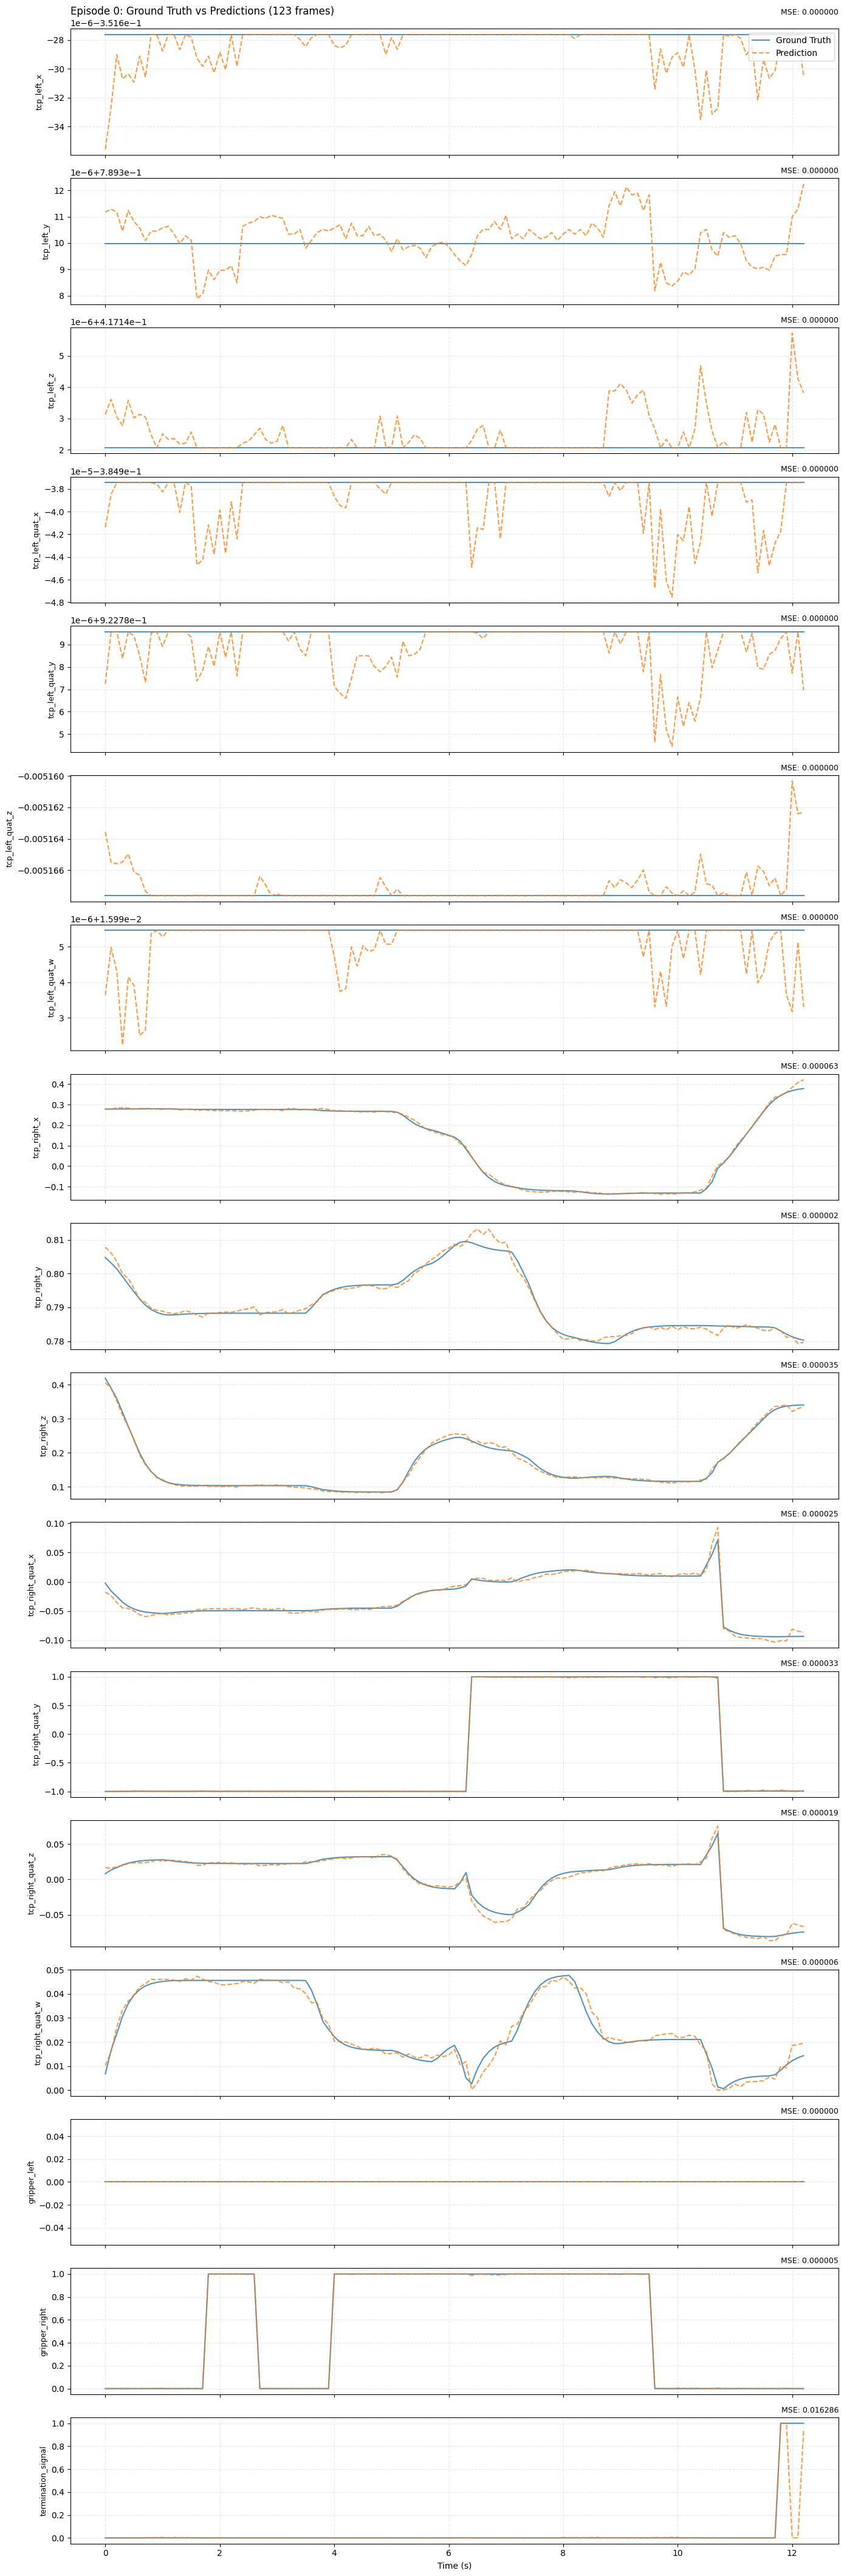

💾 Saved: validation_episode_0.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get action names from config if available
action_names = None
if hasattr(cfg, 'metadata') and cfg.metadata:
    action_names = cfg.metadata.get('features', {}).get('action', {}).get('names', None)

# Select which episode to plot (use EPISODE_INDEX from config cell)
ep_to_plot = EPISODE_INDEX

# Get dimensions
D = all_results[ep_to_plot]["targets"].shape[1]

# Create plot for single episode
targets = all_results[ep_to_plot]["targets"]
preds = all_results[ep_to_plot]["preds"]
times = all_results[ep_to_plot]["times"]
T = targets.shape[0]

fig, axes = plt.subplots(D, 1, figsize=(14, 2.5 * D), sharex=True)
if D == 1:
    axes = [axes]

for d in range(D):
    ax = axes[d]
    ax.plot(times.numpy(), targets[:, d].numpy(), label="Ground Truth", alpha=0.8, linewidth=1.5)
    ax.plot(times.numpy(), preds[:, d].numpy(), label="Prediction", alpha=0.8, linestyle='--', linewidth=1.5)
    
    # Label with action name if available
    if action_names and d < len(action_names):
        ax.set_ylabel(action_names[d], fontsize=9)
    else:
        ax.set_ylabel(f"dim {d}")
    
    ax.grid(True, linestyle="--", alpha=0.3)
    
    # Calculate and show error
    mse = ((targets[:, d] - preds[:, d]) ** 2).mean().item()
    ax.set_title(f"MSE: {mse:.6f}", fontsize=9, loc='right')
    
    if d == 0:
        ax.legend(loc='upper right')

axes[0].set_title(f"Episode {ep_to_plot}: Ground Truth vs Predictions ({T} frames)", fontsize=12, loc='left')
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# Save figure
output_path = f"validation_episode_{ep_to_plot}.pdf"
fig.savefig(output_path, bbox_inches='tight')
print(f"💾 Saved: {output_path}")
plt.close(fig)

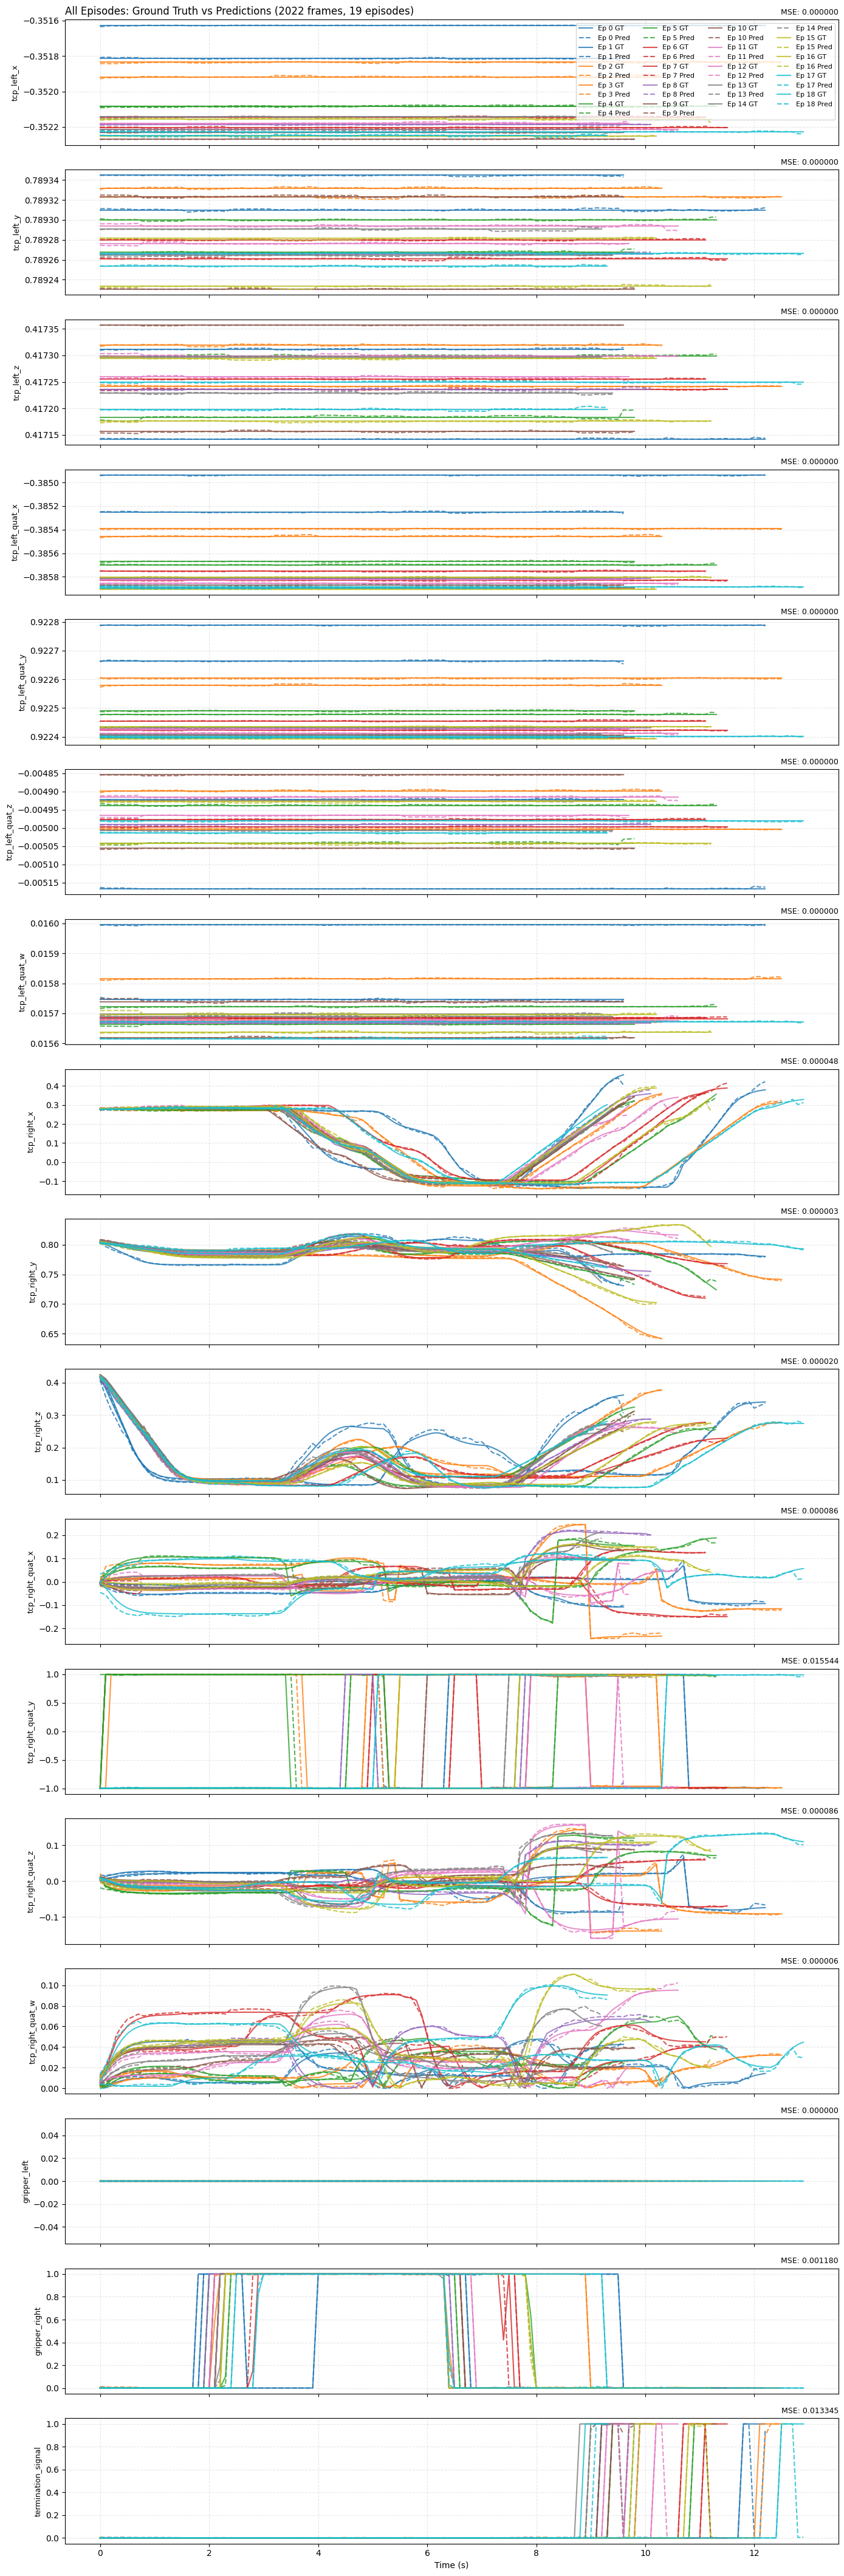

💾 Saved: validation_all_episodes.png


In [ ]:
# Plot ALL episodes together
fig, axes = plt.subplots(D, 1, figsize=(14, 2.5 * D), sharex=True)
if D == 1:
    axes = [axes]

# Color map for episodes
sorted_episodes = sorted(all_results.keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_episodes)))

total_frames = sum(len(all_results[ep]['times']) for ep in sorted_episodes)

for d in range(D):
    ax = axes[d]
    
    for idx, ep in enumerate(sorted_episodes):
        targets = all_results[ep]["targets"]
        preds = all_results[ep]["preds"]
        times = all_results[ep]["times"]
        
        color = colors[idx]
        ax.plot(times.numpy(), targets[:, d].numpy(), 
                color=color, alpha=0.8, linewidth=1.5, 
                label=f"Ep {ep} GT" if d == 0 else None)
        ax.plot(times.numpy(), preds[:, d].numpy(), 
                color=color, alpha=0.8, linestyle='--', linewidth=1.5,
                label=f"Ep {ep} Pred" if d == 0 else None)
    
    # Label with action name if available
    if action_names and d < len(action_names):
        ax.set_ylabel(action_names[d], fontsize=9)
    else:
        ax.set_ylabel(f"dim {d}")
    
    ax.grid(True, linestyle="--", alpha=0.3)
    
    # Calculate overall MSE for this dimension
    all_tgt = torch.cat([all_results[ep]["targets"][:, d] for ep in sorted_episodes])
    all_pred = torch.cat([all_results[ep]["preds"][:, d] for ep in sorted_episodes])
    mse = ((all_tgt - all_pred) ** 2).mean().item()
    ax.set_title(f"MSE: {mse:.6f}", fontsize=9, loc='right')

axes[0].set_title(f"All Episodes: Ground Truth vs Predictions ({total_frames} frames, {len(sorted_episodes)} episodes)", fontsize=12, loc='left')
axes[0].legend(loc='upper right', fontsize=8, ncol=min(len(sorted_episodes), 4))
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# Save figure
output_path = "validation_all_episodes.pdf"
fig.savefig(output_path, bbox_inches='tight')
print(f"💾 Saved: {output_path}")
plt.close(fig)

## 5. Error Analysis

In [13]:
import numpy as np

print("=" * 80)
print("ERROR ANALYSIS PER DIMENSION (AGGREGATED ACROSS ALL EPISODES)")
print("=" * 80)

# Stack all episodes together
all_targets = torch.cat([all_results[ep]["targets"] for ep in sorted(all_results.keys())], dim=0)
all_preds = torch.cat([all_results[ep]["preds"] for ep in sorted(all_results.keys())], dim=0)
all_errors = all_targets - all_preds

print(f"\nTotal frames across all episodes: {all_targets.shape[0]}")
print(f"{'Dimension':<25} {'MSE':>12} {'MAE':>12} {'Max Error':>12}")
print("-" * 80)

for d in range(D):
    name = action_names[d] if action_names and d < len(action_names) else f"dim_{d}"
    mse = (all_errors[:, d] ** 2).mean().item()
    mae = all_errors[:, d].abs().mean().item()
    max_err = all_errors[:, d].abs().max().item()
    
    print(f"{name:<25} {mse:>12.6f} {mae:>12.6f} {max_err:>12.6f}")

print("-" * 80)
total_mse = (all_errors ** 2).mean().item()
total_mae = all_errors.abs().mean().item()
print(f"{'TOTAL':<25} {total_mse:>12.6f} {total_mae:>12.6f}")

# Per-episode summary
print("\n" + "=" * 80)
print("PER-EPISODE MSE SUMMARY")
print("=" * 80)
print(f"{'Episode':<10} {'Frames':>10} {'MSE':>15} {'MAE':>15}")
print("-" * 80)

for ep in sorted(all_results.keys()):
    targets = all_results[ep]["targets"]
    preds = all_results[ep]["preds"]
    errors = targets - preds
    mse = (errors ** 2).mean().item()
    mae = errors.abs().mean().item()
    n_frames = targets.shape[0]
    print(f"{ep:<10} {n_frames:>10} {mse:>15.6f} {mae:>15.6f}")

ERROR ANALYSIS PER DIMENSION (AGGREGATED ACROSS ALL EPISODES)

Total frames across all episodes: 2022
Dimension                          MSE          MAE    Max Error
--------------------------------------------------------------------------------
tcp_left_x                    0.000000     0.000003     0.000022
tcp_left_y                    0.000000     0.000001     0.000005
tcp_left_z                    0.000000     0.000001     0.000014
tcp_left_quat_x               0.000000     0.000003     0.000021
tcp_left_quat_y               0.000000     0.000001     0.000010
tcp_left_quat_z               0.000000     0.000001     0.000012
tcp_left_quat_w               0.000000     0.000002     0.000017
tcp_right_x                   0.000048     0.004612     0.066401
tcp_right_y                   0.000003     0.001173     0.016781
tcp_right_z                   0.000020     0.002957     0.056233
tcp_right_quat_x              0.000086     0.004807     0.158159
tcp_right_quat_y              0.01554